<a href="https://colab.research.google.com/github/Dimasloop/Hyper-Parameter-Tuning-VGG19/blob/main/Keras_tuner_dari_cnn_vgg19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Reduce TensorFlow log verbosity
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0 = all messages are logged, 2 = only warnings and errors

# Importing required libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras_tuner.tuners import RandomSearch

# Dataset directories
train_dir = '/content/drive/MyDrive/Database/IsyaratBISINDO/Train_data'
eval_dir = '/content/drive/MyDrive/Database/IsyaratBISINDO/Eval_data'

In [4]:
def load_images(directory):
    images = []
    labels = []
    for idx, label in enumerate(uniq_labels):
        for file in os.listdir(directory + "/" + label):
            filepath = directory + "/" + label + "/" + file
            image = cv2.resize(cv2.imread(filepath), (224, 224))
            images.append(image)
            labels.append(idx)
    images = np.array(images)
    labels = np.array(labels)
    return(images, labels)

In [5]:
import keras

uniq_labels = sorted(os.listdir(train_dir))
images, labels = load_images(directory = train_dir)

if uniq_labels == sorted(os.listdir(eval_dir)):
    X_eval, y_eval = load_images(directory = eval_dir)

    from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, stratify = labels, random_state=0)

n = len(uniq_labels)
train_n = len(X_train)
test_n = len(X_test)

print("Total number of symbols: ", n)
print("Number of training images: " , train_n)
print("Number of testing images: ", test_n)

eval_n = len(X_eval)
print("Number of evaluation images: ", eval_n)

uniq_labels

Total number of symbols:  26
Number of training images:  7335
Number of testing images:  1834
Number of evaluation images:  9169


['A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z']

In [6]:
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test =  to_categorical(y_test)
y_eval = to_categorical(y_eval)

In [7]:
print(y_train[0])
print(len(y_train[0]))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0.]
26


In [8]:
X_train = X_train.astype('float32')/255.0
X_test = X_test.astype('float32')/255.0
X_eval = X_eval.astype('float32')/255.0

In [9]:
def build_model(hp):

  #Initialising vgg19
    classifier_vgg19 = tf.keras.applications.vgg19.VGG19(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(224,224,3),
    pooling='max',
    classes=1000,
    classifier_activation='softmax'
    )

    #don't train existing weights for vgg19
    for layer in classifier_vgg19.layers:
        layer.trainable = False

    classifier = classifier_vgg19.output#head mode
    classifier = Flatten()(classifier)#adding layer of flatten

    classifier = Dense(units=hp.Int('dense_units', min_value=64, max_value=512, step=64), activation='relu')(classifier)
    classifier = Dropout(rate=hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1))(classifier)
    # The number of output units should match the number of your classes (uniq_labels)
    classifier = Dense(len(uniq_labels), activation='softmax')(classifier)

    # Build the model with the input of the base_model defined in this function
    model = Model(inputs=classifier_vgg19.input, outputs=classifier)

    optimizer_choice = hp.Choice('optimizer', values=['adam', 'rmsprop'])
    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=hp.Float('learning_rate', 1e-5, 1e-2, sampling='log'))
    else:
        optimizer = RMSprop(learning_rate=hp.Float('learning_rate', 1e-5, 1e-2, sampling='log'))

    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Create the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='vgg19_tuner',
    project_name='vgg19_hyperparam_tuning'
)


Reloading Tuner from vgg19_tuner/vgg19_hyperparam_tuning/tuner0.json


🔍 Memulai pencarian model terbaik...
✅ Pencarian selesai.

📊 Ringkasan hasil tuning:
Results summary
Results in vgg19_tuner/vgg19_hyperparam_tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 03 summary
Hyperparameters:
dense_units: 512
dropout: 0.2
optimizer: adam
learning_rate: 0.0015589555916925512
Score: 0.977860152721405

Trial 04 summary
Hyperparameters:
dense_units: 320
dropout: 0.2
optimizer: adam
learning_rate: 0.0004529996549815218
Score: 0.9612826108932495

Trial 07 summary
Hyperparameters:
dense_units: 384
dropout: 0.2
optimizer: rmsprop
learning_rate: 0.0018290890807064876
Score: 0.9609553813934326

Trial 00 summary
Hyperparameters:
dense_units: 256
dropout: 0.4
optimizer: adam
learning_rate: 0.0006952759515727832
Score: 0.9601919651031494

Trial 01 summary
Hyperparameters:
dense_units: 448
dropout: 0.4
optimizer: rmsprop
learning_rate: 0.0007170656409278691
Score: 0.956483781337738

Trial 08 summary
Hyperparameters:
dense_units: 448
dropo

/tmp/ipython-input-1492963509.py:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(x=trial_ids, y=val_accuracies, palette='crest')


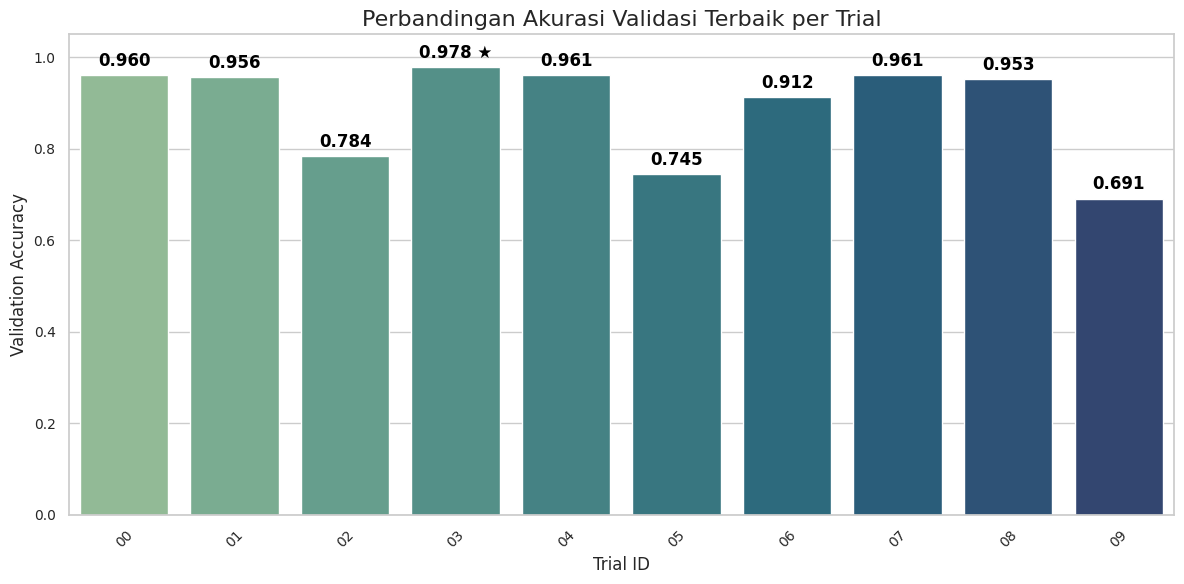

/tmp/ipython-input-1492963509.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(x=trial_ids, y=val_losses, palette='flare')


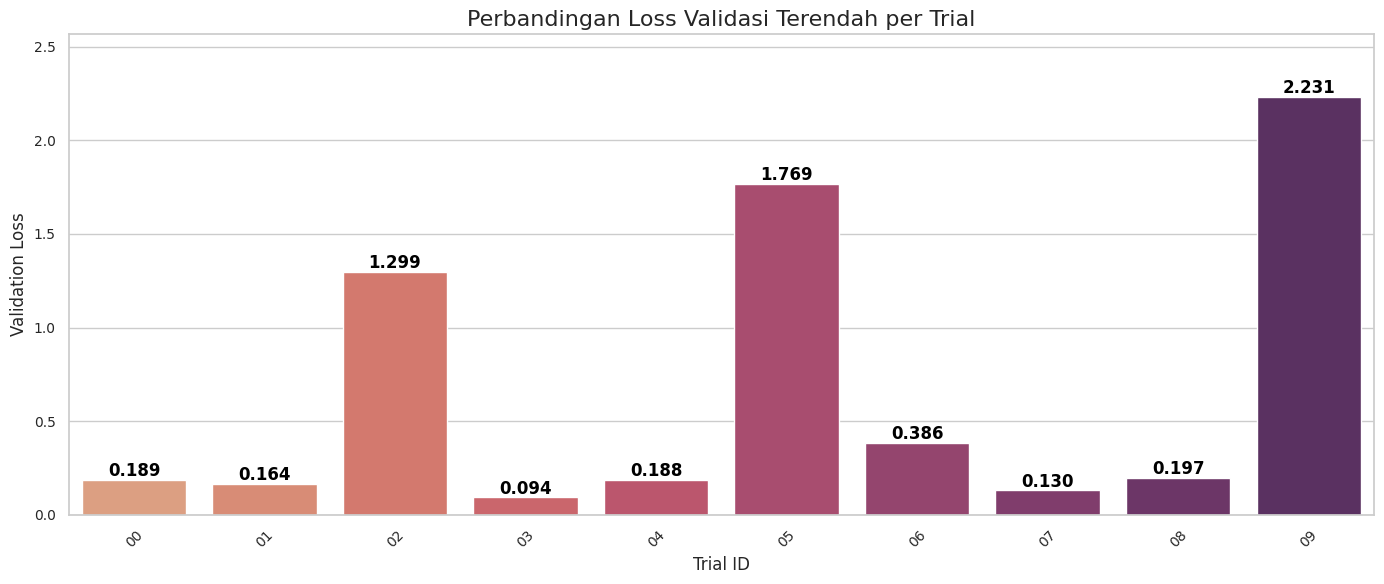


🏆 Hyperparameter terbaik yang ditemukan:
 - dense_units  : 512
 - dropout      : 0.2
 - optimizer    : adam
 - learning_rate: 0.0015589555916925512

📊 Membuat heatmap validasi akurasi berdasarkan hyperparameter...


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


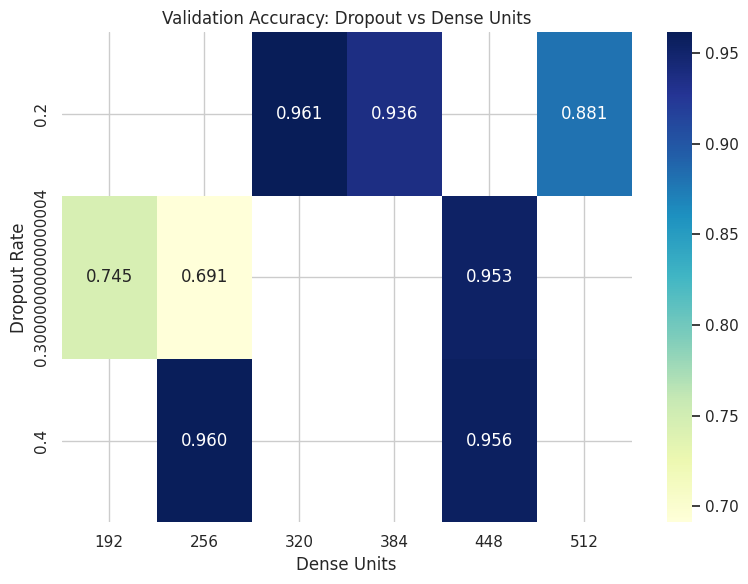

In [29]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# ===============================
# 1. Buat Dataset untuk Training & Evaluasi
# ===============================
batch_size = 64

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)) \
    .batch(batch_size).prefetch(tf.data.AUTOTUNE)

eval_dataset = tf.data.Dataset.from_tensor_slices((X_eval, y_eval)) \
    .batch(batch_size).prefetch(tf.data.AUTOTUNE)

# ===============================
# 2. Hyperparameter Tuning
# ===============================
print("🔍 Memulai pencarian model terbaik...")
tuner.search(train_dataset, epochs=15, validation_data=eval_dataset)
print("✅ Pencarian selesai.\n")

# ===============================
# 3. Ringkasan Semua Percobaan
# ===============================
print("📊 Ringkasan hasil tuning:")
tuner.results_summary()

# ===============================
# 4. Ambil Data dari Trial
# ===============================
print("\n📈 Menyiapkan grafik perbandingan val_accuracy & val_loss per trial...")

# Ambil semua trial dan urutkan berdasarkan angka di ID-nya
trials = list(tuner.oracle.trials.values())
trials_sorted = sorted(trials, key=lambda t: int(t.trial_id.split("_")[-1]))

# Ambil trial terbaik dari tuner
best_trial = tuner.oracle.get_best_trials(1)[0] # Get the best trial object
best_trial_id = best_trial.trial_id # Access the trial_id from the trial object

# Siapkan list untuk plotting
trial_ids = []
val_accuracies = []
val_losses = []

for trial in trials_sorted:
    trial_ids.append(trial.trial_id)

    # Ambil nilai terbaik dari val_accuracy
    try:
        acc = trial.metrics.get_best_value('val_accuracy')
        val_accuracies.append(float(acc) if acc is not None else 0.0)
    except:
        val_accuracies.append(0.0)

    # Ambil nilai terbaik dari val_loss
    try:
        loss = trial.metrics.get_best_value('val_loss')
        val_losses.append(float(loss) if loss is not None else 0.0)
    except:
        val_losses.append(0.0)

# ===============================
# 5. Visualisasi
# ===============================
sns.set(style='whitegrid')

# --- Plot Val Accuracy ---
plt.figure(figsize=(12, 6))  # Perbesar ukuran figure
ax1 = sns.barplot(x=trial_ids, y=val_accuracies, palette='crest')
plt.title('Perbandingan Akurasi Validasi Terbaik per Trial', fontsize=16)
plt.xlabel('Trial ID', fontsize=12)
plt.ylabel('Validation Accuracy', fontsize=12)
plt.ylim(0, 1.05)

# Tambahkan label nilai pada setiap batang
for i, acc in enumerate(val_accuracies):
    is_best = trial_ids[i] == best_trial_id
    label = f"{acc:.3f}" + (" ★" if is_best else "")
    ax1.text(i, acc + 0.02, label, ha='center', fontsize=12, fontweight='bold', color='black')

plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# --- Plot Val Loss ---
plt.figure(figsize=(14, 6))
ax2 = sns.barplot(x=trial_ids, y=val_losses, palette='flare')
plt.title('Perbandingan Loss Validasi Terendah per Trial', fontsize=16)
plt.xlabel('Trial ID', fontsize=12)
plt.ylabel('Validation Loss', fontsize=12)
plt.ylim(0, max(val_losses) * 1.15)

for i, loss in enumerate(val_losses):
    ax2.text(i, loss + 0.02, f"{loss:.3f}", ha='center', fontsize=12, fontweight='bold', color='black')

plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()
# ===============================
# 6. Tampilkan Hyperparameter Terbaik
# ===============================
best_model = tuner.get_best_models(1)[0]
print("\n🏆 Hyperparameter terbaik yang ditemukan:")
# Get the best hyperparameters from the best trial object
best_hparams = best_trial.hyperparameters
for param in best_hparams.values:
    print(f" - {param:<13}: {best_hparams.get(param)}")

# ===============================
# 7. Heatmap: Hyperparameter vs Accuracy
# ===============================
print("\n📊 Membuat heatmap validasi akurasi berdasarkan hyperparameter...")

records = []
for trial in tuner.oracle.trials.values():
    hparams = trial.hyperparameters.values
    acc = trial.metrics.get_best_value('val_accuracy')
    if acc is not None:
        records.append({**hparams, 'val_accuracy': acc})

df = pd.DataFrame(records)

if 'dropout' in df.columns and 'dense_units' in df.columns:
    pivot = df.pivot_table(values='val_accuracy', index='dropout', columns='dense_units')
    plt.figure(figsize=(8, 6))
    sns.heatmap(pivot, annot=True, fmt=".3f", cmap='YlGnBu')
    plt.title('Validation Accuracy: Dropout vs Dense Units')
    plt.xlabel('Dense Units')
    plt.ylabel('Dropout Rate')
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Kolom 'dropout' atau 'dense_units' tidak ditemukan dalam hasil tuning. Heatmap tidak dapat dibuat.")

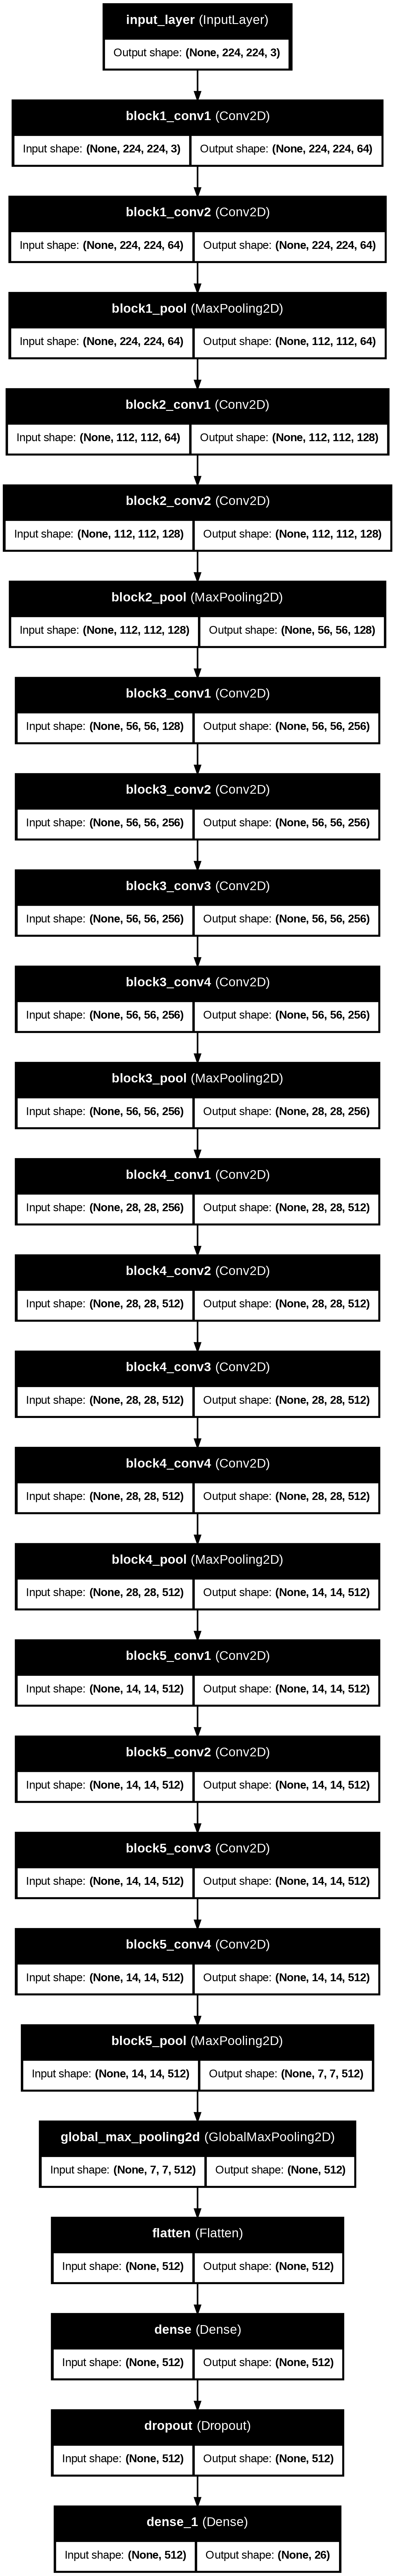

In [12]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import plot_model

plot_model(best_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [13]:
best_model.save('hpmodel_vgg19.keras')

In [14]:
from sklearn.metrics import classification_report
y_test_pred = np.around(best_model.predict(X_test))

print(classification_report(y_test, y_test_pred, zero_division=0))

58/58 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        70
           1       1.00      0.93      0.96        70
           2       0.94      0.86      0.89        69
           3       0.95      0.79      0.86        70
           4       0.98      0.91      0.95        70
           5       0.87      0.96      0.91        71
           6       0.95      0.97      0.96        72
           7       1.00      0.81      0.90        70
           8       1.00      0.86      0.93        72
           9       0.92      0.93      0.92        72
          10       0.97      0.94      0.96        70
          11       0.97      0.85      0.90        71
          12       0.95      0.80      0.87        71
          13       0.89      0.93      0.91        70
          14       1.00      0.99      0.99        71
          15       0.97      0.79      0.87        71
          16       0.97      0.94      0.

In [15]:
score = best_model.evaluate(x = X_test, y = y_test, verbose = 0)
print('Accuracy for test images:', round(score[1]*100, 3), '%')
score = best_model.evaluate(eval_dataset, verbose = 0)
print('Accuracy for evaluation images:', round(score[1]*100, 3), '%')

Accuracy for test images: 92.912 %
Accuracy for evaluation images: 97.786 %


Available keys in history.history: dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


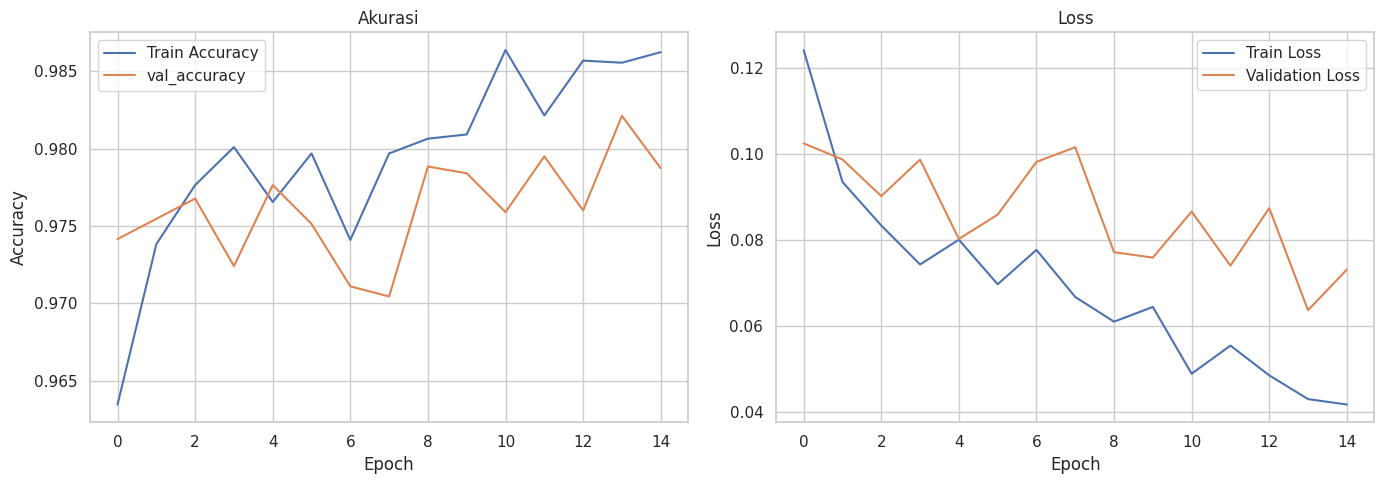

144/144 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step


In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np

# Train model terbaik
# Get the training history by fitting the best model
history = best_model.fit(train_dataset, epochs=15, validation_data=eval_dataset, verbose=0)

# Print the keys in the history.history dictionary to see available metrics
print("Available keys in history.history:", history.history.keys())

# ------------------------------
# Tampilkan grafik akurasi dan loss
# ------------------------------
plt.figure(figsize=(14, 5))

# Akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Akurasi')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# ------------------------------
# Confusion Matrix
# ------------------------------
# Prediksi label dari data evaluasi
y_pred_probs = best_model.predict(eval_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)
# Convert one-hot encoded y_eval back to class indices
y_true = np.argmax(y_eval, axis=1)

In [17]:
# Simpan model terbaik ke file
best_model.save('best_model.h5')  # atau .keras

# Simpan grafik terakhir (opsional)
plt.savefig('training_history.png')
print("📁 Model dan grafik telah disimpan.")


📁 Model dan grafik telah disimpan.


<Figure size 640x480 with 0 Axes>

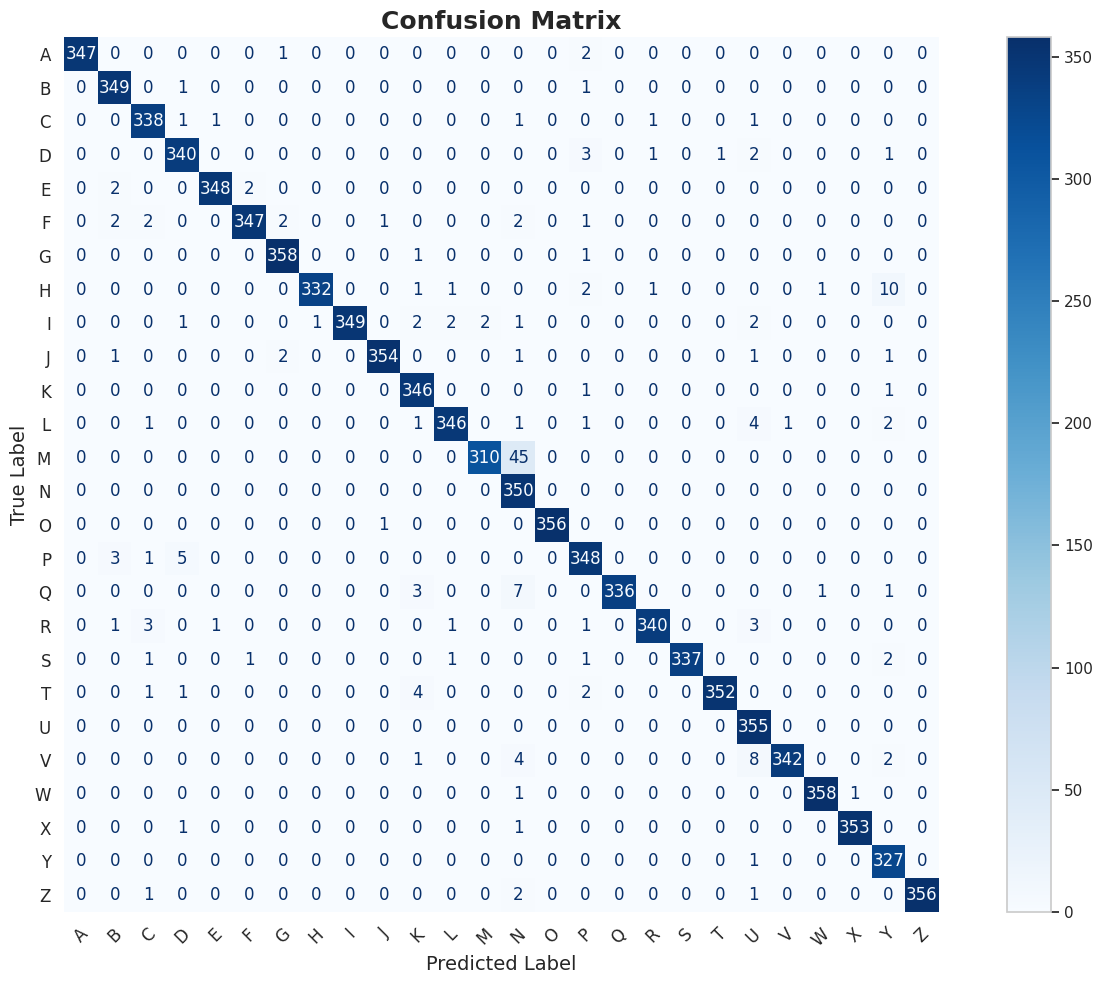

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Hitung confusion matrix
cm = confusion_matrix(y_true, y_pred)
labels = uniq_labels  # Gunakan label kelas yang bermakna

# Ukuran figure yang cukup besar
fig, ax = plt.subplots(figsize=(14, 10))

# Tampilkan confusion matrix dengan font besar dan angka jelas
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(
    cmap=plt.cm.Blues,
    xticks_rotation=45,
    ax=ax,
    values_format='d'
)

# Hilangkan garis sumbu (spines)
for spine in ax.spines.values():
    spine.set_visible(False)

# Perbesar dan tebalkan font sumbu dan judul
ax.set_title("Confusion Matrix", fontsize=18, fontweight='bold')
ax.set_xlabel("Predicted Label", fontsize=14)
ax.set_ylabel("True Label", fontsize=14)

# Ukuran font untuk tick labels
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.grid(False)

plt.tight_layout()
plt.show()

